In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()


In [2]:
from datetime import datetime, time
#import pandas_datareader.data as pdr
import pandas_datareader.data as pdr
import yfinance as yf

In [3]:
#Download historical stock data
ticker_symbol = 'AAPL'
stock_data = yf.download(tickers= ticker_symbol, start= '2010-01-01', end= '2025-01-01')
print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455077  6.391278  6.422877  493729600
2010-01-05  6.451466  6.487879  6.417459  6.458086  601904800
2010-01-06  6.348845  6.477043  6.342224  6.451464  552160000
2010-01-07  6.337108  6.379842  6.291065  6.372318  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328683  447610800


Another methods for data extraction

In [4]:
today = datetime.now().date()
five_year_ago = today.replace(year = today.year-5)
ten_year_ago = today.replace(year = today.year-10)
twenty_year_ago = today.replace(year= today.year-20)
stock_symbol = "AAPL"
try:
    data =yf.download(stock_symbol, start=ten_year_ago, end=today, rounding=True,multi_level_index=False)
    print(data.head())
except Exception as e:
    print(f"Error: {e}")

[*********************100%***********************]  1 of 1 completed

            Close   High    Low   Open     Volume
Date                                             
2015-04-06  28.44  28.48  27.77  27.80  148776000
2015-04-07  28.14  28.61  28.13  28.51  140049200
2015-04-08  28.05  28.23  27.91  28.11  149316800
2015-04-09  28.26  28.27  27.84  28.11  129936000
2015-04-10  28.38  28.41  27.97  28.13  160752000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-04-06 to 2025-04-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Open    2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


Test for Normality

In [6]:
from scipy.stats import jarque_bera

jb_stat, jb_p = jarque_bera(data['Close'])

print("Jarque-Bera statistic :", jb_stat)
print("p-value:", jb_p)

if jb_p < 0.05:
    print("the dataset is not normally distributed")
else:
    print("the dataset is normally distributed")


Jarque-Bera statistic : 230.79692155655357
p-value: 7.639857601209177e-51
the dataset is not normally distributed


Test for Autocorrelation

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljungbox_test(data, lags_list=[5,10]):
    for lag in lags_list:
        lb_test = acorr_ljungbox(data, lags= lags_list, return_df=True)

        p_value = lb_test['lb_pvalue'].iloc[0]

        if p_value > 0.05:
            interpretation = f"Fail to reject the null hypothesis at lag {lag}: No significance autocorrelation."
        else:
            interpretation = f"Reject null hypothesis at lag {lag}: Significant autocorrelation present"

        print(f"Ljung-Box test p-value for lag {lag}: {p_value:.5f}")
        print(f"Interpretation: {interpretation}")
        print()

ljungbox_test(data['Close'])

Ljung-Box test p-value for lag 5: 0.00000
Interpretation: Reject null hypothesis at lag 5: Significant autocorrelation present

Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject null hypothesis at lag 10: Significant autocorrelation present



Exploratory data analysis

In [8]:
import plotly.express as px


In [10]:
fig = px.line(data, x=data.index, y ='Close', title=f'The close price of stock {ticker_symbol}',
              labels={'Close':'Close_price$'},
              template='plotly', width=1000, height=600)
fig.update_traces(line_color = 'black')
fig.update_layout(title_font_color = 'blue', title_font_size = 20)
fig.show()

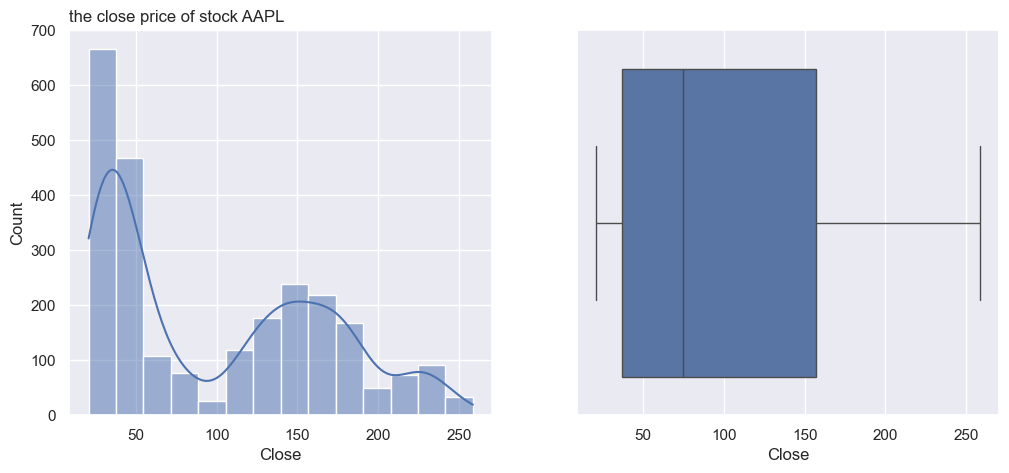

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f'the close price of stock {ticker_symbol}', loc ='left')
sns.histplot(data["Close"], kde=True)
plt.subplot(1,2,2)
sns.boxplot(data['Close'], orient='h')
plt.show()

In [13]:
from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [17]:
from scipy.stats import probplot, moment
# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

#define correlogram plot
def plot_correlogram(x,lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows= 2, ncols = 2, figsize = (12,10))
    x.plot(ax = axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

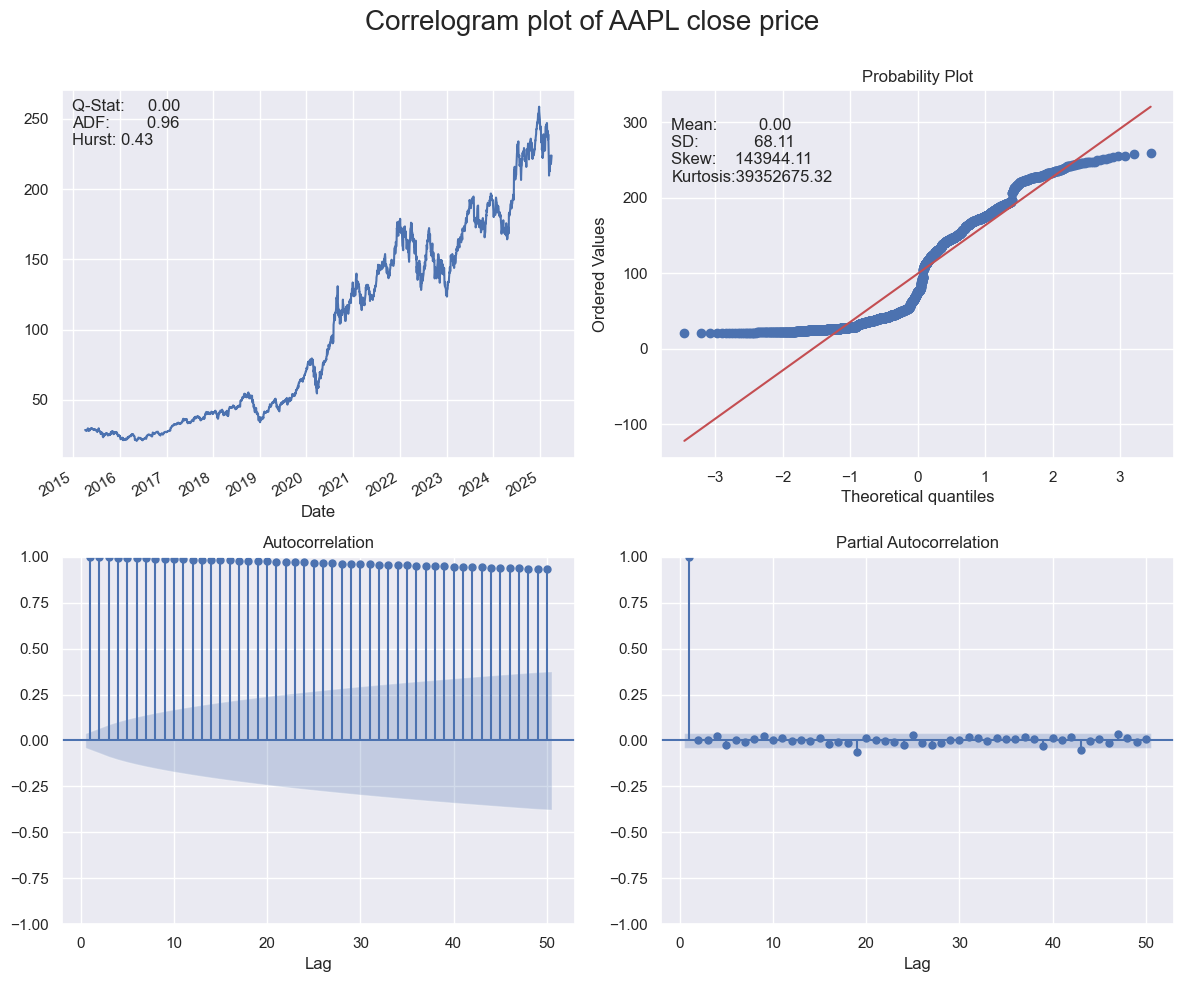

In [21]:
plot_correlogram(data['Close'], lags=50, title = f'Correlogram plot of {ticker_symbol} close price')

<Figure size 1500x1000 with 0 Axes>

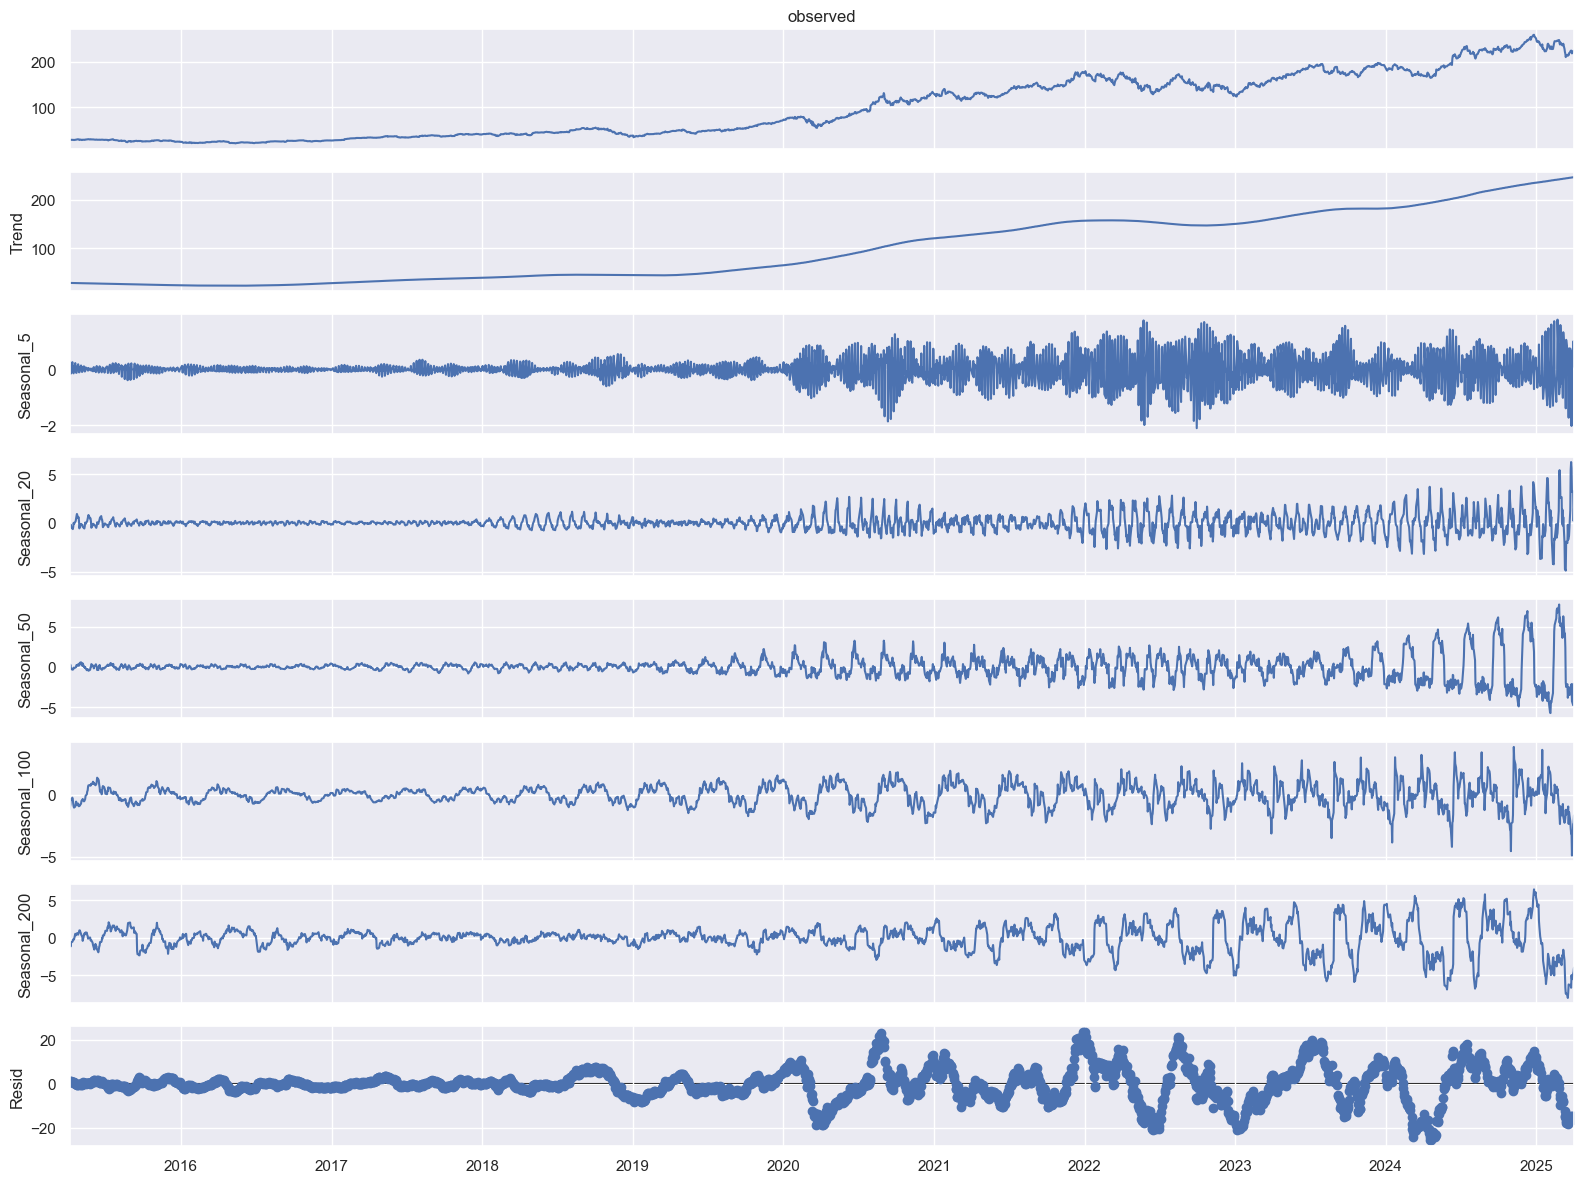

In [22]:
from statsmodels.tsa.seasonal import MSTL

plt.rc("figure", figsize=(16, 12))
plt.figure(figsize=(15,10))
# decomposited by 5,20,50,100,200-days
MSTL_result = MSTL(endog=data['Close'],  periods=(5, 20 ,50, 100, 200)).fit()

MSTL_result.plot()

plt.show()

Check any autocorrelation present in MSTL residual



In [23]:
ljungbox_test(MSTL_result.resid, [10, 15])

Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject null hypothesis at lag 10: Significant autocorrelation present

Ljung-Box test p-value for lag 15: 0.00000
Interpretation: Reject null hypothesis at lag 15: Significant autocorrelation present



When the Ljung-Box test indicates significant autocorrelation, it means that the data points in the series are not randomly distributed. Instead, past values significantly influence future values, suggesting a pattern or trend in the data.

Tets for Stationary

In [25]:
result = adfuller(data['Close'], regression= 'ctt')
print('ADF Statistics %f %result[0]')
print('p-value: %f %result[1]')
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print('Fail to reject the null hypothesis (H0), data has a unit root and is stationary.')
else:
    print('Reject the null hypothese (H0), data does not have a unit root and is stationary')


ADF Statistics %f %result[0]
p-value: %f %result[1]
Critical values:
	1%: -4.376
	5%: -3.835
	10%: -3.555
Fail to reject the null hypothesis (H0), data has a unit root and is stationary.


If a time series is non-stationary but shows significant autocorrelation, it indicates that while the data has trends or varying means over time (non-stationarity), there are also patterns where past values are influencing future values (autocorrelation).

Non-stationary data often means that mean, variance, or other statistical properties change over time. This can result from trends, seasonality, or structural changes in the data. Autocorrelation in this context suggests these patterns are not purely random but have predictable influences over time.